<h3> Сервис аренды самокатов GoFast. <a class="tocSkip"> </h3>

**Цель проекта:** проверить гипотезы, которые помогут бизнесу вырасти.
    
**Входные данные:** информация о пользователях, их поездках и подписках .
    
**Работа состоит из:**
* Загрузки данных, ознакомления с ними;
    
* Предобработки данных, удаления дублируемой информации;
    
* Исследовательского анализа данных;
    
* Объединения данных;
    
* Подсчёта выручки и проверки гипотез.

*Проект подготовил: Мамаев П.Р.*

## Загрузка данных

### Подключаем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

### Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subs = pd.read_csv('/datasets/subscriptions_go.csv')

### Изучаем основную информацию в каждом датафрейме

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
subs.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Данные в читаемом формате, всё понятно. 

Единственное, колонка с датой в `rides` в неверном формате, исправим это в следующем пункте.

## Предобработка данных

### Приведеные данных к нужному формату

Приводим столбец с датой в нужный формат

In [9]:
rides['date'] = pd.to_datetime(rides['date'], format = '%Y-%m-%d')

Привели данный столбик к нужному формату, проверим.

In [10]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


##### Создаем новый столбец с номером месяца

Cоздадим новый столбец в данном датафрейме с номером месяца.

In [11]:
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [12]:
rides['date'].dt.year.unique()

array([2021])

### Поиск пропусков

In [13]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [14]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [15]:
subs.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Отлично, в данных отсутствуют пропуски. 

Теперь проверим на наличие дублирующихся строк.

### Поиск дубликатов

In [16]:
users.duplicated().sum()

31

В датафрейме `users` есть дублирующиеся строчки, избавимся от них.

В остальных двух таблицах таковых не имеется.

In [17]:
users = users.drop_duplicates()
users = users.reset_index(drop=True)

In [18]:
users.duplicated().sum()

0

Данные удалены, всё хорошо.

## Исследовательский анализ данных

### Частота встречаемости городов

In [19]:
popular_cities = users.value_counts('city')
popular_cities

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
dtype: int64

Text(0, 0.5, 'Количество пользователей')

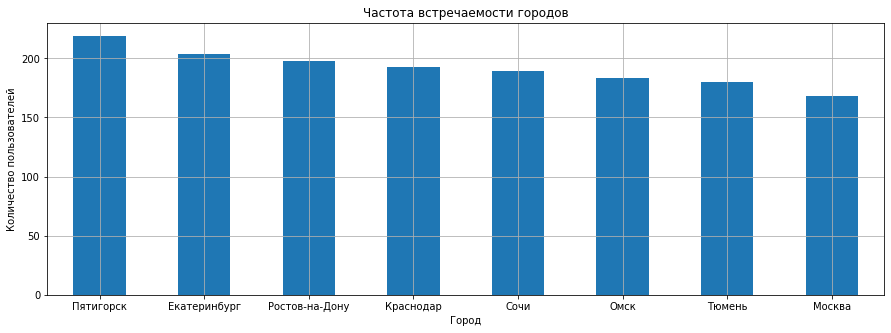

In [20]:
(
    popular_cities
    .plot(kind='bar', grid=True, figsize=(15, 5), legend=False, rot=0, title='Частота встречаемости городов')
)
plt.xlabel('Город')
plt.ylabel('Количество пользователей')

Сервис **GoFast** наиболее популярен в Пятигорске и менее - в Москве.

### Соотношение пользователей с подпиской и без подписки

In [21]:
users_ratio = users.value_counts('subscription_type')
users_ratio

subscription_type
free     835
ultra    699
dtype: int64

Text(0, 0.5, 'Подписка')

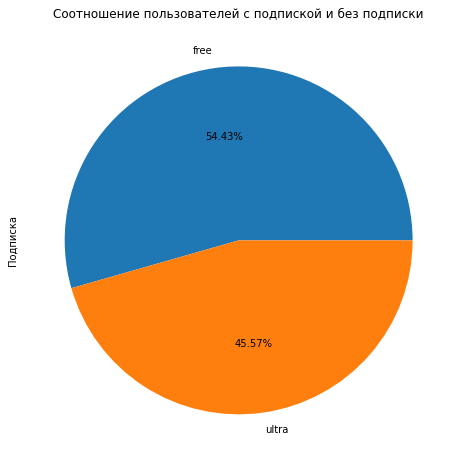

In [22]:
users_ratio.plot(kind='pie', figsize=(8,8), autopct= "%.2f%%", title='Соотношение пользователей с подпиской и без подписки')
plt.ylabel('Подписка')

У сервиса **GoFast** чуть менее половины пользователей имеют месячную подписку. Это отличный результат!

### Возраст пользователей

In [23]:
users['age'].median()

25.0

Медианный возраст пользователя сервиса - 25 лет.

Text(0, 0.5, 'Количество пользователей')

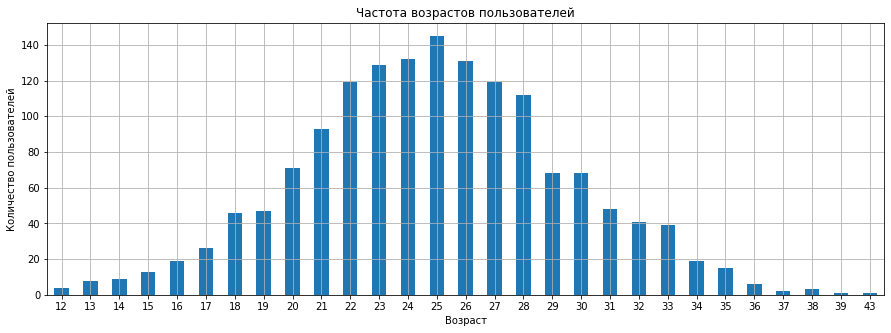

In [24]:
age_ratio = (
    users
    .value_counts('age')
    .sort_index()
    .plot(kind='bar', grid=True, figsize=(15, 5), legend=False, rot=0, title='Частота возрастов пользователей')
)
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')

Из диаграммы видно, что сервис наиболее популярен у молодых людей и девушек возрастом 22-28 лет.

### Расстояние, которое пользователь преодолел за одну поездку

Text(0, 0.5, 'Частота')

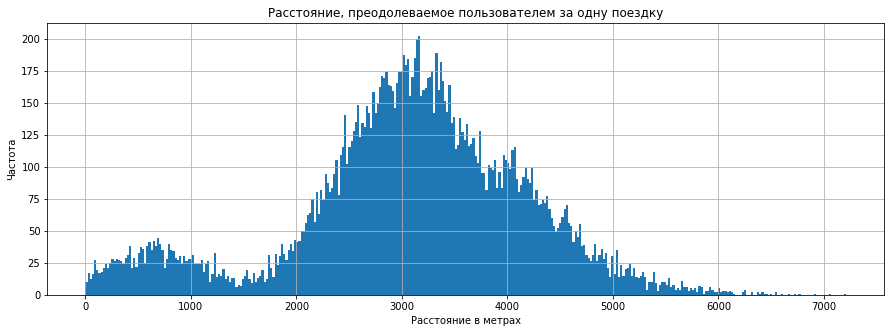

In [25]:
user_distance = (
    rides['distance']
    .plot(kind='hist', bins=350, figsize=(15, 5), grid=True, title='Расстояние, преодолеваемое пользователем за одну поездку')
)
plt.xlabel('Расстояние в метрах')
plt.ylabel('Частота')

Чаще всего пользователи проезжают на самокатах сервиса порядка 2500-3500 метров.

### Продолжительность поездок

Text(0, 0.5, 'Частота')

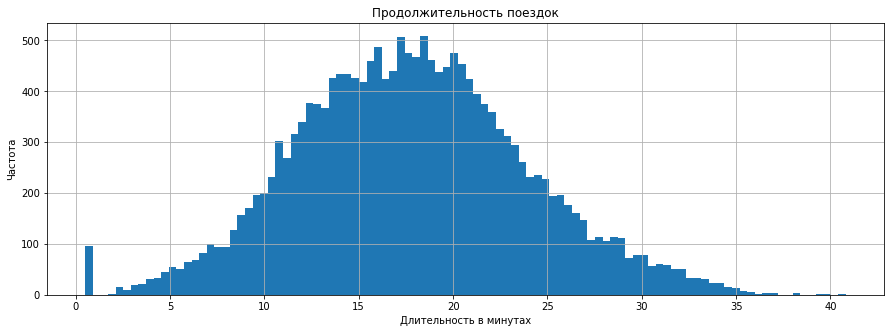

In [26]:
rides_duration = (
    rides['duration']
    .plot(kind='hist', bins=100, figsize=(15, 5), grid=True, title='Продолжительность поездок')
)
plt.xlabel('Длительность в минутах')
plt.ylabel('Частота')

Типичная длительность поездки в сервисе **GoFast** составляет 15-20 минут.

Text(0, 0.5, 'Частота')

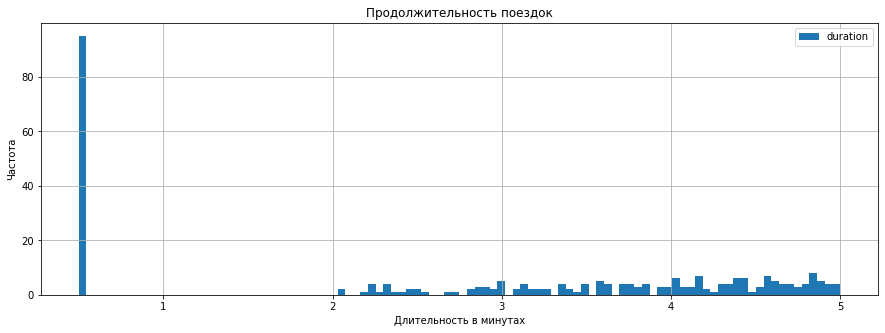

In [27]:
rides_duration = (
    rides.query('0 < duration < 5')
    .plot(y='duration', kind='hist', bins=100, figsize=(15, 5), grid=True, title='Продолжительность поездок')
)
plt.xlabel('Длительность в минутах')
plt.ylabel('Частота')

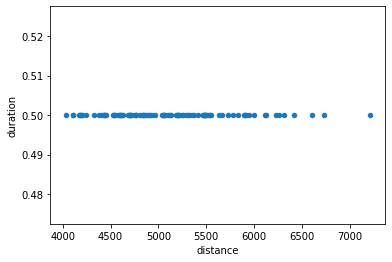

In [28]:
zero_duration = (
    rides
    .query('duration <= 1')
    .plot(x='distance', y='duration', kind='scatter')
)

**ВЫВОД ПО ПУНКТУ:**

* Сервис наиболее популярен в Пятигорске, наименее - в Москве;

* Соотношение пользователей с подпиской и без подписки - 45% к 55%;

* **GoFast** пользуются преимущественно молодые люди от 20 до 30 лет;

* Медианная поездка составляет около 3100 метров;

* Типичная длительность поездки - 15-20 минут. Есть всплеск значений у нуля, но это можно объяснить стартом и резким завершением поездки по причине списания денег за старт.

## Объединение данных

### Объединяем таблицы в одну

In [29]:
data = users.merge(rides, on='user_id')
data.shape[0]

18068

In [30]:
data = data.merge(subs, on='subscription_type')
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [31]:
data.shape[0]

18068

Таблицы объединили, никакие данные не потеряли.

### Создаем ещё два дополнительных датафрейма

#### Таблица с пользователями платной подписки

In [32]:
ultras = data[data['subscription_type'] == 'ultra']
ultras.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


#### Таблица с пользователями без подписки

In [33]:
frees = data[data['subscription_type'] == 'free']
frees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  float64       
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int64         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


В сумме данные две таблицы дают 18068: 11568 + 6500. Значит, никакие данные не утеряны.

### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

#### Расстояние и время поездок для пользователей с подпиской

Text(0, 0.5, 'Количество поездок')

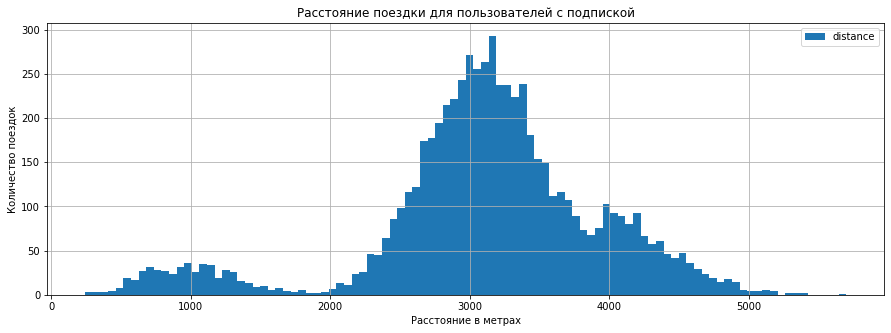

In [34]:
ultras_distance = (
    ultras
    .plot(y='distance', kind='hist', bins=100, figsize=(15,5), grid=True, title='Расстояние поездки для пользователей с подпиской')
)
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')

In [35]:
ultras['distance'].median()

3148.6372291760854

**Пользователи с подпиской чаще всего ездят на расстояние от 2500 до 3500 метров. Медианным значением является 3148 метров.**

Text(0, 0.5, 'Количество поездок')

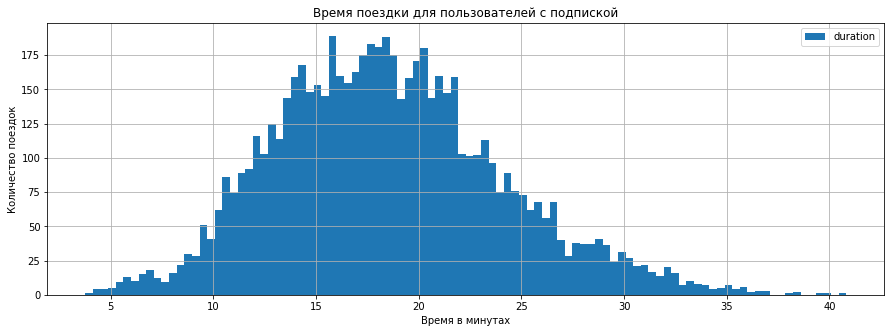

In [36]:
ultras_duration = (
    ultras
    .plot(y='duration', kind='hist', bins=100, figsize=(15,5), grid=True, title='Время поездки для пользователей с подпиской')
)
plt.xlabel('Время в минутах')
plt.ylabel('Количество поездок')

In [37]:
ultras['duration'].median()

18.17815320055055

**Типичная длительность поездки пользователей с подпиской составляет от 13 до 22 минут. Медианным значением является 18 минут.**

#### Расстояние и время поездок для пользователей без подписки

Text(0, 0.5, 'Количество поездок')

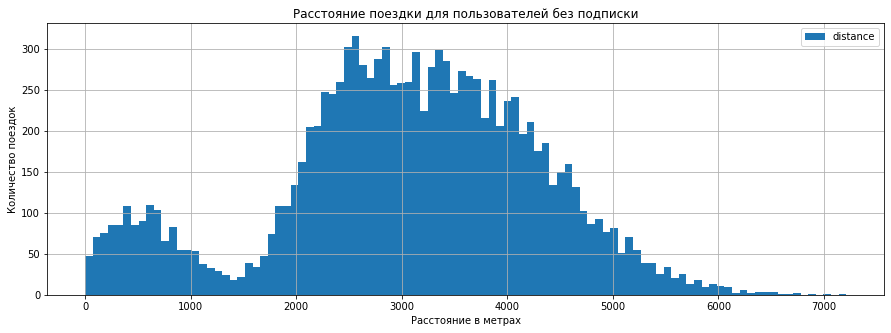

In [38]:
frees_distance = (
    frees
    .plot(y='distance', kind='hist', bins=100, figsize=(15,5), grid=True, title='Расстояние поездки для пользователей без подписки')
)
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')

In [39]:
frees['distance'].median()

3114.648464847295

**График расстояния поездки для пользователей без подписки более плавный с правой стороны, нет нетипичного взлета поездок на 4 километрах. Типичная дальность поездки составляет 2000-5000 метров, разброс довольно большой. Медианное расстояние поездки составляет 3114 метра.**

Text(0, 0.5, 'Количество поездок')

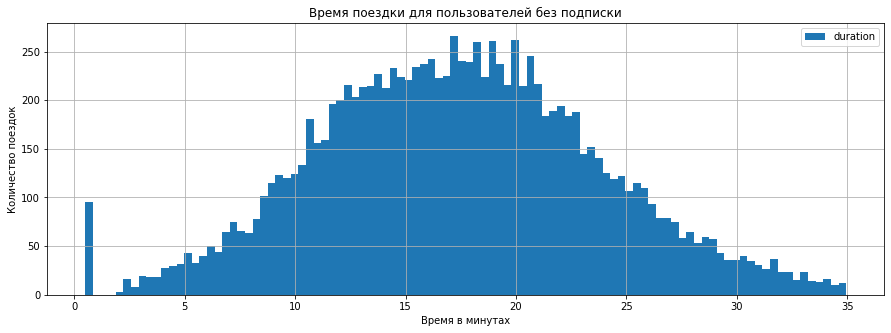

In [40]:
frees_duration = (
    frees
    .plot(y='duration', kind='hist', bins=100, figsize=(15,5), grid=True, title='Время поездки для пользователей без подписки')
)
plt.xlabel('Время в минутах')
plt.ylabel('Количество поездок')

In [41]:
frees['duration'].median()

17.326890226082043

**График без резких взлетов, более плавный, но и данных у нас почти в 2 раза больше, чем по пользователям с подпиской. Медианное значение составляет 17 минут.**

Совместим обе категории пользователей на одном графике. Сначала расстояние

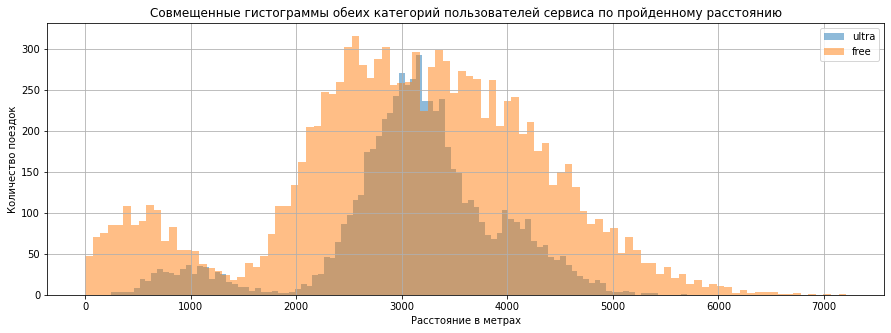

In [42]:
(
    ultras['distance']
    .hist(bins=100, figsize=(15,5), alpha=0.5, grid=True, label = 'ultra')
)   
(
    frees['distance']
    .hist(bins=100, figsize=(15,5), alpha=0.5, grid=True, label = 'free')
)

plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Совмещенные гистограммы обеих категорий пользователей сервиса по пройденному расстоянию')
plt.legend()
plt.show()

Теперь длительность поездки.

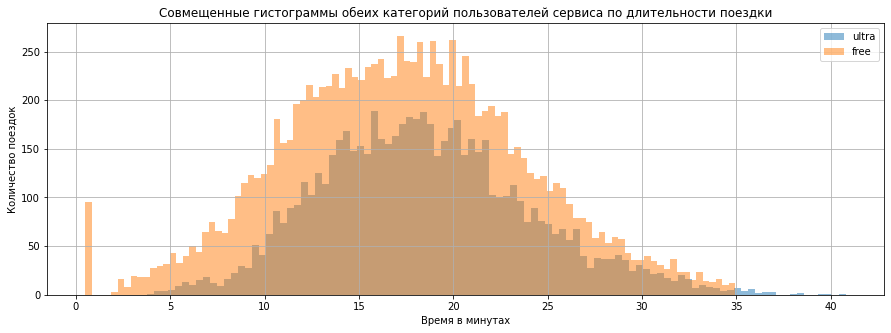

In [43]:
(
    ultras['duration']
    .hist(bins=100, figsize=(15,5), alpha=0.5, grid=True, label = 'ultra')
)   
(
    frees['duration']
    .hist(bins=100, figsize=(15,5), alpha=0.5, grid=True, label = 'free')
)

plt.xlabel('Время в минутах')
plt.ylabel('Количество поездок')
plt.title('Совмещенные гистограммы обеих категорий пользователей сервиса по длительности поездки')
plt.legend()
plt.show()

**ВЫВОД ПО ПУНКТУ:**

*Расстрояние поездки:*

Для пользователей с подпиской она более однозначна, в то время как для пользователей без подписки разброс большой. Однако, медианные значения фактически равны: 3148 метра против 3144 метра.

*Длительность поездки:*

Опять же, графики похожи. Для пользователей с подпиской можно выделить диапазон, без подписки - нет. Медианные значения отличаются на почти на минуту. Также, обратим внимание на взлет окончания поездок у пользователей без подписки на первой минуте. Моё предположение - люди видят, что за старт снимают 50 рублей, расстраиваются и заканчивают поездку.

## Подсчёт выручки

### Агрегация данных

Для корректной работы с данными округлим продолжительность каждой поездки пользователя до целых чисел

In [44]:
data['duration'] = np.ceil(data['duration'])

In [45]:
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199


In [46]:
grouped_data = (
    data
    .pivot_table(index=['user_id','month'], values=['distance','duration','subscription_type','minute_price','start_ride_price','subscription_fee'], aggfunc=({'distance':'sum','duration':['count','sum'],'subscription_type':'first','minute_price':'first','start_ride_price':'first','subscription_fee':'first'}))
)
grouped_data

distance duration       minute_price start_ride_price  \
                        sum    count   sum        first            first   
user_id month                                                              
1       1       7027.511294        2  42.0            6                0   
        4        754.159807        1   7.0            6                0   
        8       6723.470560        2  46.0            6                0   
        10      5809.911100        2  32.0            6                0   
        11      7003.499363        3  56.0            6                0   
...                     ...      ...   ...          ...              ...   
1534    6       3409.468534        2  26.0            8               50   
        8       7622.453034        2  48.0            8               50   
        9       4928.173852        1  23.0            8               50   
        11     13350.015305        4  78.0            8               50   
        12      2371.711192        1  16.0            8               50   

              subscription_fee subscription_type  
                         first             first  
user_id month                                     
1       1                  199             ultra  
        4                  199             ultra  
        8                  199             ultra  
        10                 199             ultra  
        11                 199             ultra  
...                        ...               ...  
1534    6                    0              free  
        8                    0              free  
        9                    0              free  
        11                   0              free  
        12                   0              free  

[11331 rows x 7 columns]

Да, группировка с `pivot_table` выглядит не очень изящно, зато работает.

Переименуем столбцы для удобства ориентирования в таблице.

In [47]:
grouped_data.columns = ['distance_sum','rides_amount','rides_duration','minute_price','start_ride_price','subscription_fee','subscription_type']
grouped_data

distance_sum  rides_amount  rides_duration  minute_price  \
user_id month                                                             
1       1       7027.511294             2            42.0             6   
        4        754.159807             1             7.0             6   
        8       6723.470560             2            46.0             6   
        10      5809.911100             2            32.0             6   
        11      7003.499363             3            56.0             6   
...                     ...           ...             ...           ...   
1534    6       3409.468534             2            26.0             8   
        8       7622.453034             2            48.0             8   
        9       4928.173852             1            23.0             8   
        11     13350.015305             4            78.0             8   
        12      2371.711192             1            16.0             8   

               start_ride_price  subscription_fee subscription_type  
user_id month                                                        
1       1                     0               199             ultra  
        4                     0               199             ultra  
        8                     0               199             ultra  
        10                    0               199             ultra  
        11                    0               199             ultra  
...                         ...               ...               ...  
1534    6                    50                 0              free  
        8                    50                 0              free  
        9                    50                 0              free  
        11                   50                 0              free  
        12                   50                 0              free  

[11331 rows x 7 columns]

### Добавление столбца с помесячной выручкой

In [48]:
grouped_data['month_income'] = (
    grouped_data['rides_amount'] * grouped_data['start_ride_price'] 
    + grouped_data['minute_price'] * grouped_data['rides_duration']
    + grouped_data['subscription_fee']
)

In [49]:
grouped_data.head(10)

distance_sum  rides_amount  rides_duration  minute_price  \
user_id month                                                             
1       1       7027.511294             2            42.0             6   
        4        754.159807             1             7.0             6   
        8       6723.470560             2            46.0             6   
        10      5809.911100             2            32.0             6   
        11      7003.499363             3            56.0             6   
        12      6751.629942             2            28.0             6   
2       3      10187.723006             3            63.0             6   
        4       6164.381824             2            40.0             6   
        6       3255.338202             1            14.0             6   
        7       6780.722964             2            48.0             6   

               start_ride_price  subscription_fee subscription_type  \
user_id month                                                         
1       1                     0               199             ultra   
        4                     0               199             ultra   
        8                     0               199             ultra   
        10                    0               199             ultra   
        11                    0               199             ultra   
        12                    0               199             ultra   
2       3                     0               199             ultra   
        4                     0               199             ultra   
        6                     0               199             ultra   
        7                     0               199             ultra   

               month_income  
user_id month                
1       1             451.0  
        4             241.0  
        8             475.0  
        10            391.0  
        11            535.0  
        12            367.0  
2       3             577.0  
        4             439.0  
        6             283.0  
        7             487.0

Успешно получилось добавить столбцев с месячной выручкой для каждого пользователя.

**ВЫВОД ПО ПУНКТУ:**

Округлил время до целых значений, сгруппировал информацию по пользователям и месяцам.

Также, добавил месячную выручку для каждого пользователя.

## Проверка гипотез

### Время поездок пользователей с подпиской

h0: *Пользователи с подпиской тратят столько же времени на поездки, сколько и пользователи без подписки.*

h1: *Пользователи с подпиской тратят больше времени на поездки, чем и пользователи без подписки.*

Данные будем анализировать по исходным, не агрегированным, данным.

In [50]:
ultras_duration = ultras['duration']
frees_duration = frees['duration']

alpha = 0.05

results = st.ttest_ind(ultras_duration, frees_duration, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергать нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Значение `p-value` оказалось меньше, чем значение уровня статистической значимости.

Соответственно, **нулевая гипотеза о равенстве времени на поездку у разных категорий пользователей отвергается.**
Пользователи с подпиской тратят больше времени на поездки, чем и пользователи без подписки.

### Среднее расстояние, проезжаемое пользователями с подпиской

h0: *Среднее расстояние, которое проезжают пользователи с подпиской не превышает 3130 метров.*

h1: *Среднее расстояние, которое проезжают пользователи с подпиской более 3130 метров.*

In [51]:
ultras_distance = ultras['distance']
optimal_distance = 3130

alpha = 0.05

results = st.ttest_1samp(ultras_distance, optimal_distance, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергать нулевую гипотезу')

p-значение: 0.9195368847849785
Нет оснований отвергать нулевую гипотезу


В данном случае мы можем утверждать, что **пользователи с подпиской действительно проезжают не более 3130 метров.**

### Помесячная выручка от разных категорий пользователей

h0: *Пользователи с подпиской приносят сервису столько же месячной выручки, сколько и пользователи без подписки.*

h1: *Пользователи с подпиской приносят сервису больше месячной выручки в сравнении с пользователями без подписки.*

In [52]:
ultras_income = grouped_data[grouped_data['subscription_type'] == 'ultra']['month_income']
frees_income = grouped_data[grouped_data['subscription_type'] == 'free']['month_income']

alpha = 0.05

results = st.ttest_ind(ultras_income, frees_income, alternative='greater')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергать нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Есть все основания полагать, что **пользователи с платной подпиской приносят больше выручки, чем пользователи без подписки.**

### Количество обращений в техподдержку

h0: *Количество обращений в техподдержку не изменилось.*

h1: *Количество обращений в техподдержку снизилось.*

```python
before_update = your_data_before
after_update = your_data_after

alpha = 0.05 #Также можем воспользоваться значением 0.01

results = st.ttest_rel(after_update, before_update, alternative='less')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергать нулевую гипотезу')
```

Шаблон сделан, осталось лишь добавить необходимую информацию.

**ВЫВОД ПО ПУНКТУ:**

*Гипотеза №1* - отвергнута.

*Гипотеза №2* - не отвергнута.

*Гипотеза №3* - отвергнута.

*Гипотеза №4* - шаблон готов, ждём информацию от технической команды.

## Общий вывод по работе:

В данной проекте я работал с генеральной выборкой загруженых данных.

* Данные были изученны и отчищены от дублирующихся строк. Пустых значений не было. Строки с датой изменил под стандартный формат.

* У сервиса по аренде самокатов **GoFast** больше всего пользователей в Пятигорске. Соотношение платных и бесплатных пользователей 45% к 55%, что действительно удивляет, это очень хорошее отношение. 

* Типичная аудитория: 22-28 лет.

* Длительность поездки 15-20 минут.

* Расстояние - 3100 метров.

Сравнивая пользователей с подпиской и без, было обнаружено, что медианная длительность и медианное расстрояние поездки почти равны для обеих категорий.

Также, мною были сгруппированны данные по пользователям и месяцам, была посчитана выручка для каждого пользователя.

В п.6 было рассмотрено четыре разных гипотезы, из которых:

* *Пользователи с подпиской тратят больше времени на поездки, чем и пользователи без подписки* - отвергнута. Пользователи с подпиской тратят больше времени на поездки, чем и пользователи без подписки.

* *Пользователи с подпиской проезжают не более 3130 метров.* - не отвергнута. Действительно, так и есть.

* *Пользователи с подпиской приносят сервису столько же месячной выручки, сколько и пользователи без подписки.* - отвергнута. Пользователи с подпиской действительно приносят больше выручки.

* *количество обращений в техподдержку снизилось* - данную гипотезу проверить или опровергнуть нельзя в связи с отсутствием данных.